# streamfunction_vorticity_iterative_solver

> An iterative solver for the full Navier-Stokes equations in the streamfunction-vorticity form

In [ ]:
#| default_exp streamfunction_vorticity

# Introduction

Integrate in time the vorticity equation.

Run the simple code first.

1. Then change to $Re=10$, $nx=11$, $dt=0.035$, $dpic=0.025$ and $tfinal=0.525$. The plot of the streamfunction should show the numerical instability. Decreasing $dt$ to 0.03 nearly stabilises the result at this $tfinal$, while $dt=0.025$ works to $tfinal=3.0$. This value of $dt$ is the marginal value, but that is for large grids, and small grids are slightly more stable. Best to work at $dt=0.2*Re*h*h$

1. The code first calculates the boundary conditions to first-order, and then extrapolates these results to apply the conditions to second-order. Use this second-order code. Change to  $Re=10$, $nx=11$, $dpic=0.1$ and $tfinal=1.0$ and $dt=0.02$. Find the value of $\omega(x=0.5,y=0.5,t=1.0)$. Now decrease $dt$ to 0.01, 0.005, 0.0025 and 0.001. Then with $nx=15$ try $dt$ = 0.01 (largest stable value), 0.005, 0.0025 and 0.001. Finally with $nx=21$ try $dt=$ 0.005 (largest stable value), 0.0025 and 0.001. Plot these results for $\psi(x=0.5,y=0.5,t=1.0)$ as a function of $dt$. **You could experiment by deleting the lines of the code that apply the boundary conditions at second-order.**

1. Now set $tfinal=3.0$, $dpic=0.1$ and $dt=0.2*Re*h*h$ and obtain $\omega(x=0.5,y=0.5,t)$ to find how long it takes the vorticity to attain a steady value within 4 significant figures. Compare your plots for the steady state of the streamfunction and the vorticity.

1. Gather results for different spatial resolutions $nx$ for the steady horizontal velocity $u$ at the mid-section $x=0.5$, and plot on top of one another.

1. The code calculates the force on the top plate to second-order accuracy. Find the steady force for different spatial resolutions, $nx=11$, 15, 21, 29 and 41. Plot the force as a function of the grid size $h$.

1. Change the top slip boundary condition from $u=\sin^2\pi x$ to $u=1$, i.e change

    $$
    w(i,nx)= -(sin(pi*(i-1)*h)*sin(pi*(i-1)*h)... 
    $$

    to

    $$
    w(i,nx) = -1...
    $$

    Find the force on the top plate for various spatial resolutions, say $nx= 10$, 14, 20, 28 and 40. **Show that the force diverges as the resolution increases as $F = 4.32\ln(1/h) - 3.75$.**

# Imports

In [ ]:
# Autoreload modules
%load_ext autoreload
%autoreload 2

In [ ]:
#| export
from uom_project import core, poisson_solvers

import numpy as np

In [ ]:
from collections import defaultdict

import matplotlib.pyplot as plt
from matplotlib import cm

# Code for the solver

In [ ]:
#| exporti

def update_vorticity_bcs(w, psi, U_wall_top, nx, ny, h):
    # First calculate BCs to 1st order

    # y = 0: U_wall = 0
    w[1:nx - 1, 0] = -(
        (psi[1:nx - 1, 1] - psi[1:nx - 1, 0]) / h - 0
    ) / (0.5 * h)
    # y = 1: U_wall_top is given here
    w[1:nx - 1, ny - 1] = -(
        U_wall_top -
        (psi[1:nx - 1, ny - 1] - psi[1:nx - 1, ny - 2]) / h
    ) / (0.5 * h)
    
    # x = 0: U_wall = 0
    w[0, 1:ny - 1] = (
        -(psi[1, 1:ny - 1] - psi[0, 1:ny - 1]) / h - 0
    ) / (0.5 * h)
    # x = 1: U_wall = 0
    w[nx - 1, 1:ny - 1] = (
        0 - (-(psi[nx - 1, 1:ny - 1] - psi[nx - 2, 1:ny - 1]) / h)
    ) / (0.5 * h)

    
    # Compute the 2nd order correction to the BCs
    w[1:nx - 1, 0] = (4 * w[1:nx - 1, 0] - w[1:nx - 1, 1]) / 3 # y = 0
    w[1:nx - 1, ny - 1] = (
        4 * w[1:nx - 1, ny - 1] - w[1:nx - 1, ny - 2]
    ) / 3 # y = 1
    
    w[0, 1:ny - 1] = (4 * w[0, 1:ny - 1] - w[1, 1:ny - 1]) / 3 # x = 0
    w[nx - 1, 1:ny - 1] = (
        4 * w[nx - 1, 1:ny - 1] - w[nx - 2, 1:ny - 1]
    ) / 3 # x = 1

    return w


def get_dw_dt(dw_dt, w, psi, Re, nx, ny, h):
    dw_dt[1:nx - 1, 1:ny - 1] = (
        -(
            (psi[1:nx - 1, 2:ny] - psi[1:nx - 1, 0:ny - 2]) *
            (w[2:nx, 1:ny - 1] - w[0:nx - 2, 1:ny - 1])
        ) / (4 * h ** 2) + 
        (
            (psi[2:nx, 1:ny - 1] - psi[0:nx - 2, 1:ny - 1]) *
            (w[1:nx - 1, 2:ny] - w[1:nx - 1, 0:ny - 2])
        ) / (4 * h ** 2) + 
        (
            w[2:nx, 1:ny - 1] + w[0:nx - 2, 1:ny - 1] +
            w[1:nx - 1, 2:ny] + w[1:nx - 1, 0:ny - 2] -
            4 * w[1:nx - 1 , 1:ny - 1]
        ) / (Re * h ** 2)
    )

    return dw_dt


In [ ]:
#| export

# Incorporates both the Poisson problem and time-stepping for the vorticity
def streamfunction_vorticity_iterative_solver(
    N, Re, tfinal, U_wall_top, dt=None,
    algorithm="base", print_every=0.0
):
    nx = ny = N + 1 # i.e. N = 10
    h = 1 / N # h = dx (=dy) = 1 / N; x-size is 1, y-size is ny/nx
    
    w = np.zeros(shape=(nx, ny)) # vorticity
    psi = np.zeros(shape=(nx, ny)) # streamfunction
    dw_dt = np.zeros(shape=(nx, ny)) # dw/dt    
    
    if dt is None:
        dt = np.round(0.2 * Re * h ** 2, 8) # 0.8 * marginal value
    
    omega_mid = []
    
    t = 0
    while t < tfinal:
        # Start by solving the Poisson problem
        psi = poisson_solvers.poisson_non_iterative_solver(
            w, algorithm=algorithm
        )

        # Now time-step vorticity
        w = update_vorticity_bcs(w, psi, U_wall_top, nx, ny, h)

        # We can now find dw/dt
        dw_dt = get_dw_dt(dw_dt, w, psi, Re, nx, ny, h)

        # Finally, update w
        w[1:nx-1, 1:ny-1] = w[1:nx-1, 1:ny-1] + dw_dt[1:nx-1, 1:ny-1] * dt
        
        # One pass done, increment time
        t = np.round(t + dt, 8)
        
        # Print
        if print_every > 0:
            if 0 <= np.round(t % print_every, 8) < dt:
                print(f"t={t:.5f}; w(0.5, 0.5)={w[nx // 2, ny // 2]}")
        
        omega_mid.append(w[nx // 2, ny // 2])
    
    return w, psi, np.array(omega_mid)


# Initialization

In [ ]:
%%time

dpic = 0.5

N = 10
Re = 10 # i.e. mu = 0.1

tfinal = 3.0
dt = 0.2 * Re / (N ** 2)

# We'll only need these later
nx, ny, x_grid, y_grid = core.setup_poisson_problem(N=N)[2:]
h = 1 / N

U_wall_top = np.sin(np.pi * np.arange(1, nx - 1) * h) ** 2

w, psi, _ = streamfunction_vorticity_iterative_solver(
    N=N, Re=Re, tfinal=tfinal, U_wall_top=U_wall_top, dt=dt, print_every=dpic
)

t=0.50000; w(0.5, 0.5)=-0.5444996676781466
t=1.00000; w(0.5, 0.5)=-0.6387054908937547
t=1.50000; w(0.5, 0.5)=-0.6449327255957606
t=2.00000; w(0.5, 0.5)=-0.6453438810250036
t=2.50000; w(0.5, 0.5)=-0.6453710324565722
t=3.00000; w(0.5, 0.5)=-0.6453728255099435
CPU times: user 181 ms, sys: 5.15 ms, total: 186 ms
Wall time: 234 ms


# Results

## Plots

In [ ]:
# Helper function for plotting
def plot(x, y, z, label, zlim, levels, offset, figsize=(10, 10), plot_contour=True):
    ax = plt.figure(figsize=figsize).add_subplot(projection="3d")

    # Plot the surface
    ax.plot_surface(x, y, z)
    
    if plot_contour:
        ax.contour(
            x, y, z, levels=levels,
            zdir="z", offset=offset, cmap=cm.binary
        )
        ax.set(zlim=zlim)

    ax.set(
        xlabel="x", ylabel="y", zlabel=label,
    )

    plt.show()

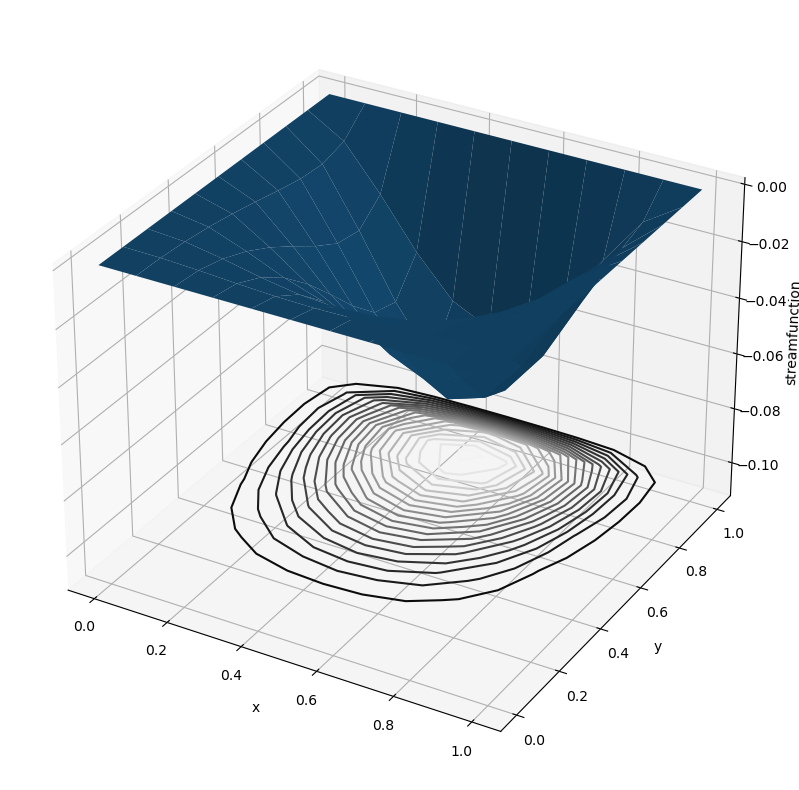

In [ ]:
plot(
    x=x_grid, y=y_grid, z=psi,
    label="streamfunction", levels=20,
    offset=-0.1, zlim=(-0.11, 0)
)

In [ ]:
def find_min(z):
    return np.unravel_index(z.argmin(), z.shape)

In [ ]:
# Min location
min_location = find_min(psi)
min_location, (x_grid[min_location], y_grid[min_location]), psi[min_location]

((5, 8), (0.5, 0.8), -0.07791119833961699)

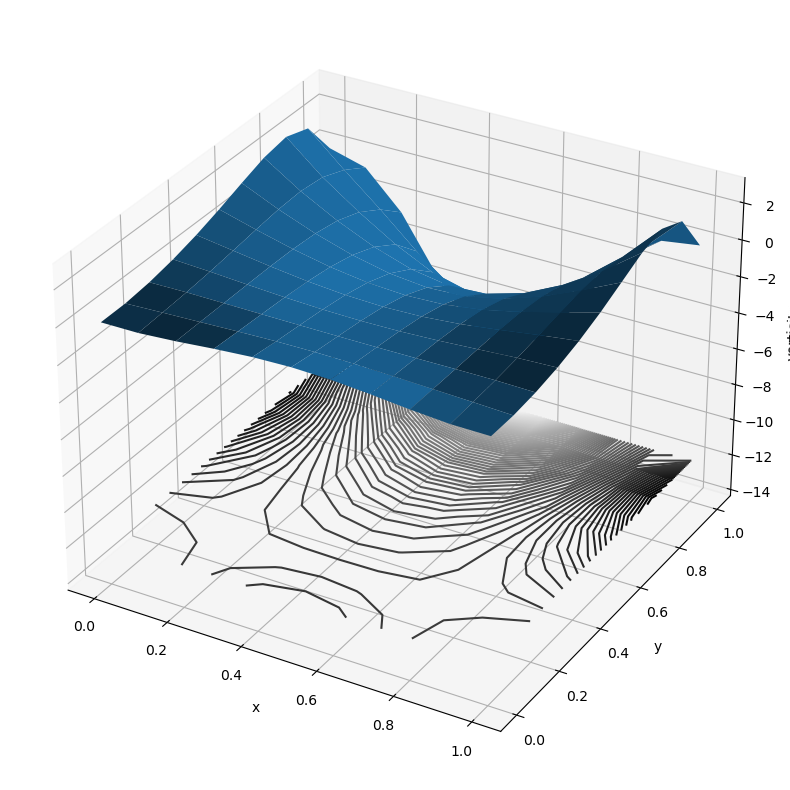

In [ ]:
plot(
    x=x_grid, y=y_grid, z=w,
    label="vorticity", levels=80,
    offset=-12, zlim=(-14, 3)
)

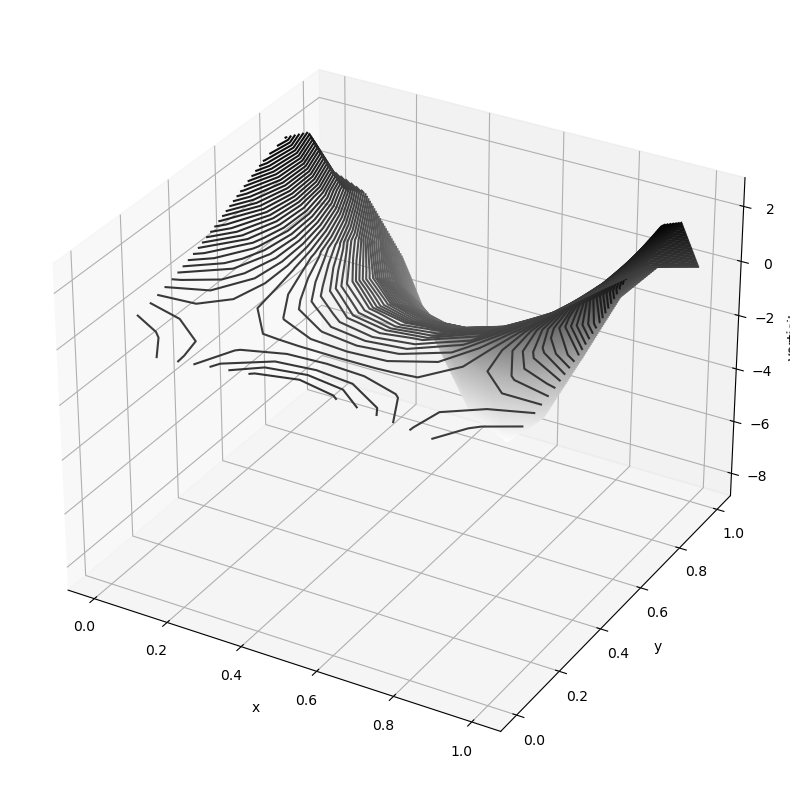

In [ ]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection="3d")

ax.contour3D(x_grid, y_grid, w, levels=145, cmap="binary")
ax.set(
    xlabel="x", ylabel="y", zlabel="vorticity",
)

plt.show()

In [ ]:
# Min location
min_location = find_min(w)
min_location, (x_grid[min_location], y_grid[min_location]), w[min_location]

((5, 10), (0.5, 1.0), -8.628818063104957)

## Calculating u at middle

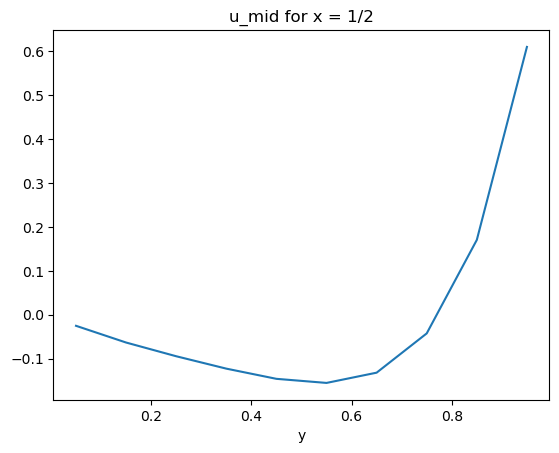

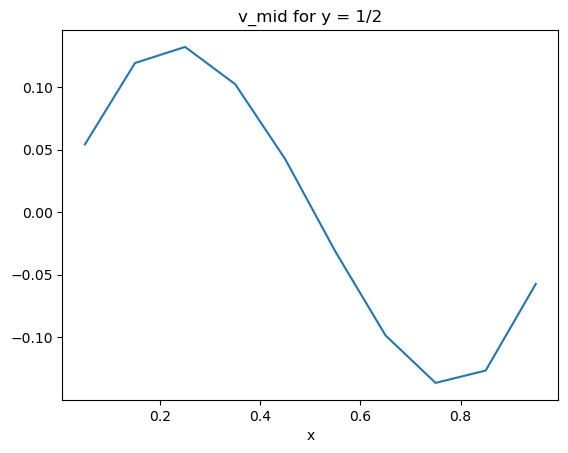

In [ ]:
i = nx // 2
u_mid = (psi[i, 1:] - psi[i, :-1]) / h
plt.plot(y_grid[i, :-1] + h / 2, u_mid)
plt.title("u_mid for x = 1/2")
plt.xlabel("y");
plt.show()

j = nx // 2
v_mid = -(psi[1:, j] - psi[:-1, j]) / h
plt.plot(x_grid[:-1, j] + h / 2, v_mid)
plt.title("v_mid for y = 1/2")
plt.xlabel("x");
plt.show()

## Calculating force

In [ ]:
core.calculate_force(psi)

3.402638419034052

# Exercise 1

In [ ]:
%%time

# Should be unstable

dpic = 0.025

N = 10
Re = 10 # i.e. mu = 0.1

tfinal = 0.525
dt = 0.035

# We'll only need these later
nx, ny, x_grid, y_grid = core.setup_poisson_problem(N=N)[2:]
h = 1 / N

U_wall_top = np.sin(np.pi * np.arange(1, nx - 1) * h) ** 2

w, psi, _ = streamfunction_vorticity_iterative_solver(
    N=N, Re=Re, tfinal=tfinal, U_wall_top=U_wall_top, dt=dt, print_every=dpic
)

t=0.03500; w(0.5, 0.5)=0.0
t=0.07000; w(0.5, 0.5)=0.0
t=0.10500; w(0.5, 0.5)=0.0
t=0.14000; w(0.5, 0.5)=0.0
t=0.17500; w(0.5, 0.5)=-0.13931894170892972
t=0.21000; w(0.5, 0.5)=-0.18114096125256485
t=0.24500; w(0.5, 0.5)=-0.28328266579353845
t=0.28000; w(0.5, 0.5)=-0.3302452365489448
t=0.31500; w(0.5, 0.5)=-0.39469983866086544
t=0.35000; w(0.5, 0.5)=-0.428705105391505
t=0.38500; w(0.5, 0.5)=-0.5160377369989643
t=0.42000; w(0.5, 0.5)=-0.3361440321601029
t=0.45500; w(0.5, 0.5)=-1.0618105769330133
t=0.49000; w(0.5, 0.5)=0.9000017370543836
t=0.52500; w(0.5, 0.5)=-4.158806562460364
CPU times: user 41.8 ms, sys: 2.33 ms, total: 44.1 ms
Wall time: 103 ms


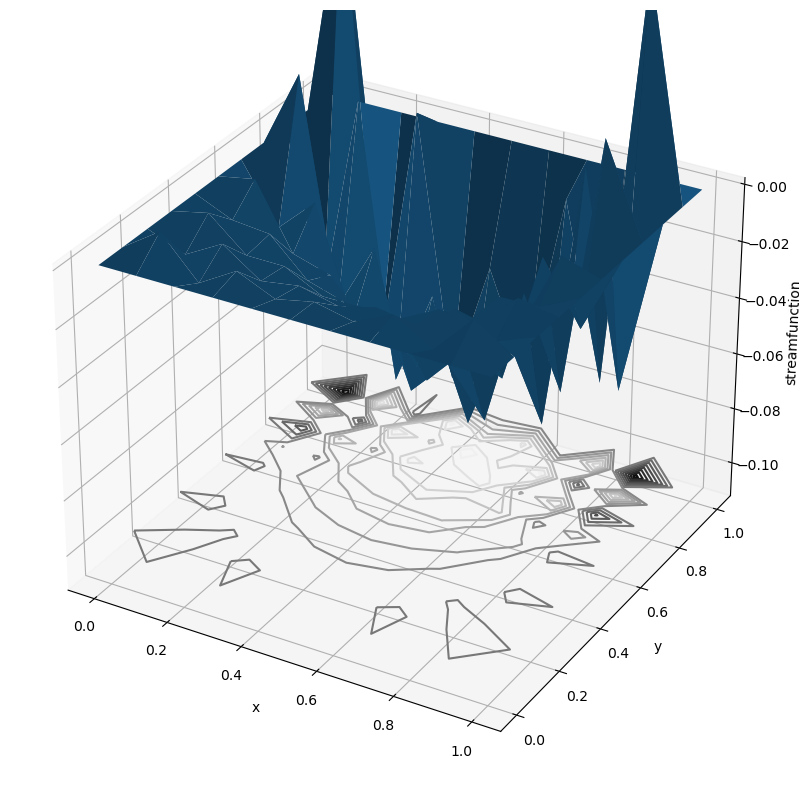

In [ ]:
plot(
    x=x_grid, y=y_grid, z=psi,
    label="streamfunction", levels=20,
    offset=-0.1, zlim=(-0.11, 0)
)

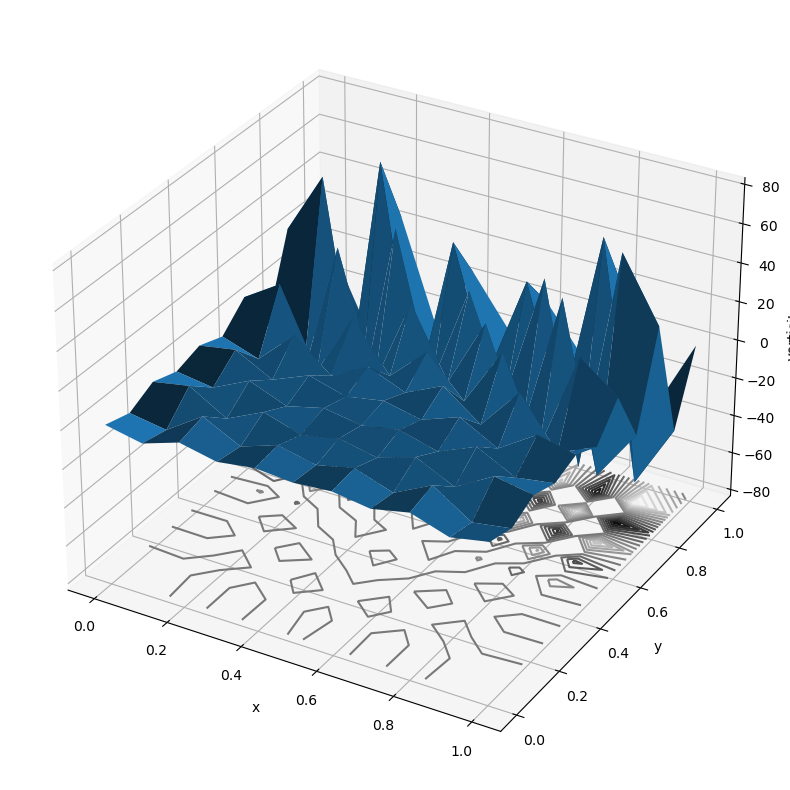

In [ ]:
plot(
    x=x_grid, y=y_grid, z=w,
    label="vorticity", levels=20,
    offset=-80, zlim=(-80, 80)
)

In [ ]:
xyz = np.vstack([x_grid.flatten(), y_grid.flatten(), w.flatten()]).T
print(xyz.shape)

# np.savetxt('data/vorticity/vorticity_instability.txt', xyz, delimiter=' ', fmt=['%.8f', '%.8f', '%.18f'])
# np.savetxt('data/vorticity/instability.txt', xyz, delimiter=' ', fmt='%.18f')

(121, 3)


In [ ]:
%%time

# Almost stable

dpic = 0.025

N = 10
Re = 10 # i.e. mu = 0.1

tfinal = 0.525
dt = 0.03

# We'll only need these later
nx, ny, x_grid, y_grid = core.setup_poisson_problem(N=N)[2:]
h = 1 / N

U_wall_top = np.sin(np.pi * np.arange(1, nx - 1) * h) ** 2

w, psi, _ = streamfunction_vorticity_iterative_solver(
    N=N, Re=Re, tfinal=tfinal, U_wall_top=U_wall_top, dt=dt, print_every=dpic
)

t=0.03000; w(0.5, 0.5)=0.0
t=0.06000; w(0.5, 0.5)=0.0
t=0.09000; w(0.5, 0.5)=0.0
t=0.12000; w(0.5, 0.5)=0.0
t=0.15000; w(0.5, 0.5)=-0.0645363232858129
t=0.18000; w(0.5, 0.5)=-0.12702767457933217
t=0.21000; w(0.5, 0.5)=-0.19576752262286123
t=0.24000; w(0.5, 0.5)=-0.25778785383766345
t=0.27000; w(0.5, 0.5)=-0.31399128196568515
t=0.30000; w(0.5, 0.5)=-0.36184849862584695
t=0.33000; w(0.5, 0.5)=-0.4112617346981654
t=0.36000; w(0.5, 0.5)=-0.42698443654212387
t=0.39000; w(0.5, 0.5)=-0.5068251143020296
t=0.42000; w(0.5, 0.5)=-0.4338368094308288
t=0.45000; w(0.5, 0.5)=-0.641247170292879
t=0.48000; w(0.5, 0.5)=-0.3373820457738828
t=0.51000; w(0.5, 0.5)=-0.891398349205351
t=0.54000; w(0.5, 0.5)=-0.03965063476739894
CPU times: user 46.7 ms, sys: 2.36 ms, total: 49 ms
Wall time: 103 ms


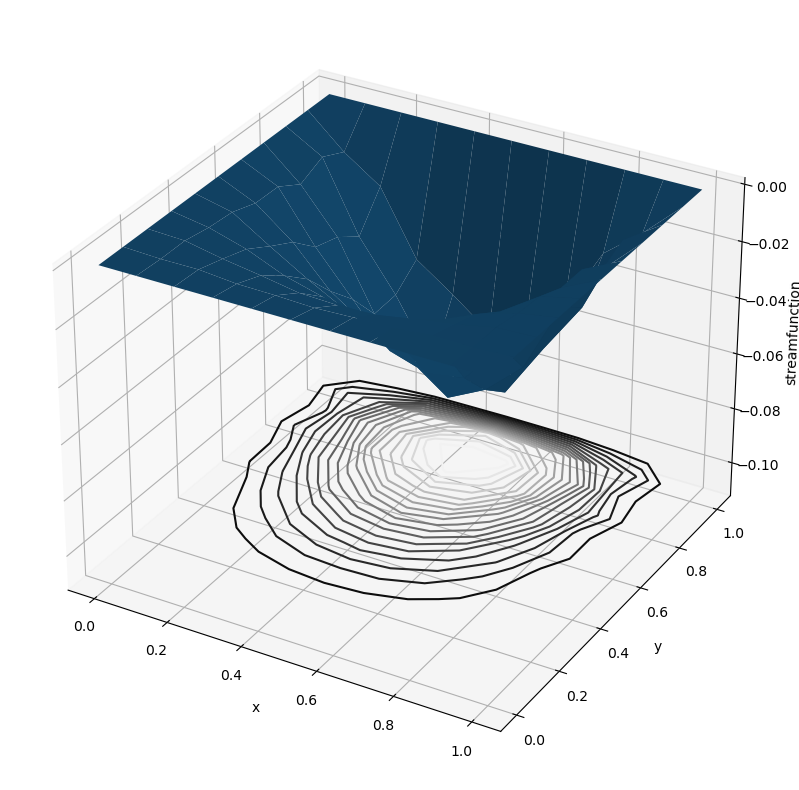

In [ ]:
plot(
    x=x_grid, y=y_grid, z=psi,
    label="streamfunction", levels=20,
    offset=-0.1, zlim=(-0.11, 0)
)

In [ ]:
%%time

# Stable

dpic = 0.025

N = 10
Re = 10 # i.e. mu = 0.1

tfinal = 3.0
dt = 0.025 # marginal value

# We'll only need these later
nx, ny, x_grid, y_grid = core.setup_poisson_problem(N=N)[2:]
h = 1 / N

U_wall_top = np.sin(np.pi * np.arange(1, nx - 1) * h) ** 2

w, psi, _ = streamfunction_vorticity_iterative_solver(
    N=N, Re=Re, tfinal=tfinal, U_wall_top=U_wall_top, dt=dt
)

CPU times: user 299 ms, sys: 6.58 ms, total: 306 ms
Wall time: 439 ms


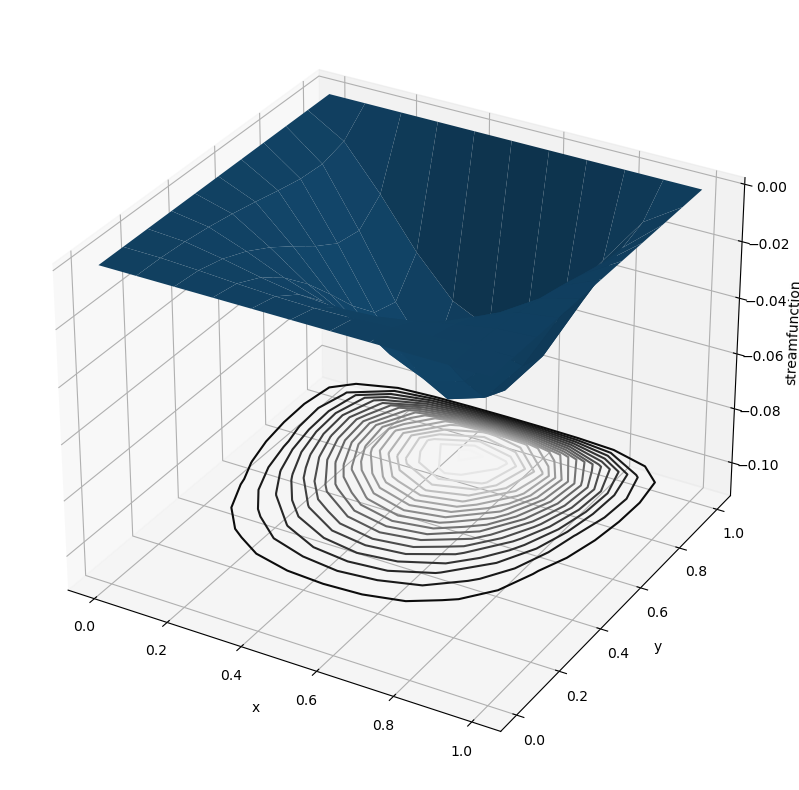

In [ ]:
plot(
    x=x_grid, y=y_grid, z=psi,
    label="streamfunction", levels=20,
    offset=-0.1, zlim=(-0.11, 0)
)

# Exercise 2

In [ ]:
%%time


N_to_t = {
    10: [0.02, 0.01, 0.005, 0.0025, 0.001],
    14: [0.01, 0.005, 0.0025, 0.001],
    20: [0.005, 0.0025, 0.001],
}
results = defaultdict(list)

dpic = 0.1

Re = 10 # i.e. mu = 0.1

tfinal = 1.0

for N, dts in N_to_t.items():
    U_wall_top = np.sin(np.pi * np.arange(1, N) / N) ** 2
    for dt in dts:
        w, psi, _ = streamfunction_vorticity_iterative_solver(
            N=N, Re=Re, tfinal=tfinal, U_wall_top=U_wall_top, dt=dt
        )
        
        results[N].append(w[(N + 1) // 2, (N + 1) // 2])

CPU times: user 19.6 s, sys: 464 ms, total: 20.1 s
Wall time: 33.5 s


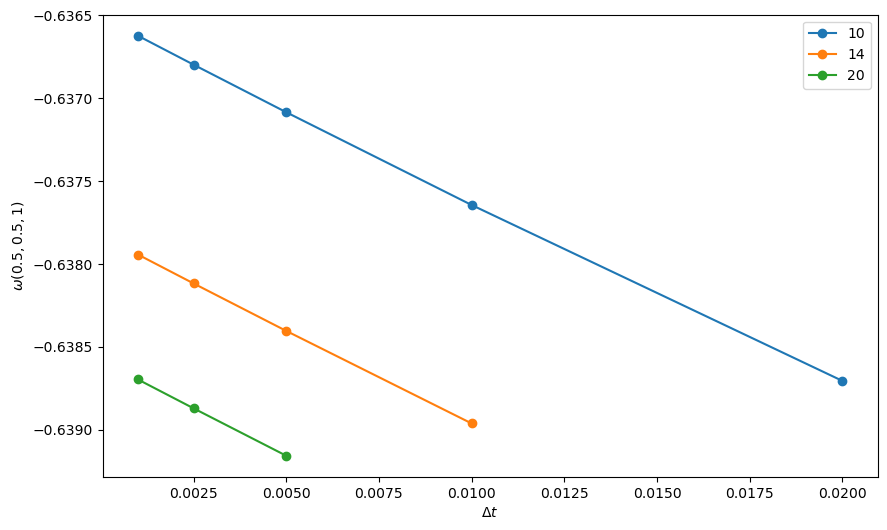

In [ ]:
plt.figure(figsize=(10, 6))

for N, omegas in results.items():
    plt.plot(N_to_t[N], omegas, label=N, marker="o")

plt.xlabel(r"$\Delta t$")
plt.ylabel(r"$\omega(0.5, 0.5, 1)$")
plt.legend()
plt.show()

In [ ]:
# for N, omegas in results.items():
#     Nw = np.vstack([
#         N_to_t[N], omegas
#     ]).T
#     print(Nw.shape)
#     print(Nw)
#     print()

#     np.savetxt(f'data/vorticity/omega_vs_dt_{N}.txt', Nw, delimiter=' ', fmt=['%.18f', '%.18f'])

# Exercise 3

In [ ]:
%%time

# Stable

dpic = 0.5

N = 40
Re = 10 # i.e. mu = 0.1

tfinal = 3.0

# We'll only need these later
nx, ny, x_grid, y_grid = core.setup_poisson_problem(N=N)[2:]
h = 1 / N

U_wall_top = np.sin(np.pi * np.arange(1, nx - 1) * h) ** 2

w, psi, omega_mid = streamfunction_vorticity_iterative_solver(
    N=N, Re=Re, tfinal=tfinal, U_wall_top=U_wall_top, print_every=dpic
)

t=0.50000; w(0.5, 0.5)=-0.5318447876735226
t=1.00000; w(0.5, 0.5)=-0.6392098284826704
t=1.50000; w(0.5, 0.5)=-0.6470228354189802
t=2.00000; w(0.5, 0.5)=-0.6475894272266987
t=2.50000; w(0.5, 0.5)=-0.6476306076189362
t=3.00000; w(0.5, 0.5)=-0.647633477499898
CPU times: user 24.3 s, sys: 494 ms, total: 24.8 s
Wall time: 34.5 s


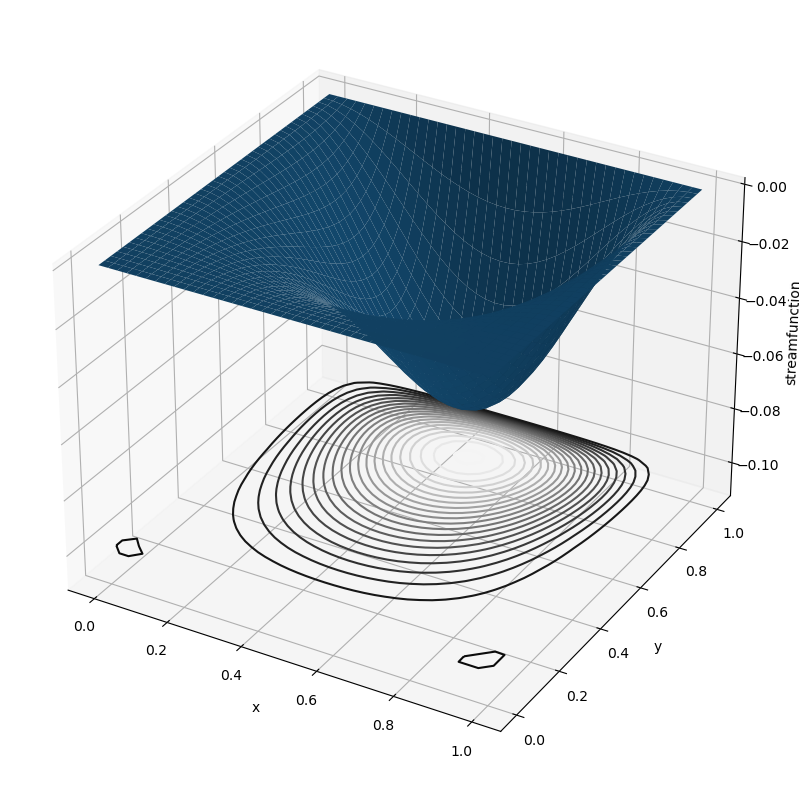

In [ ]:
plot(
    x=x_grid, y=y_grid, z=psi,
    label="streamfunction", levels=20,
    offset=-0.1, zlim=(-0.11, 0)
)

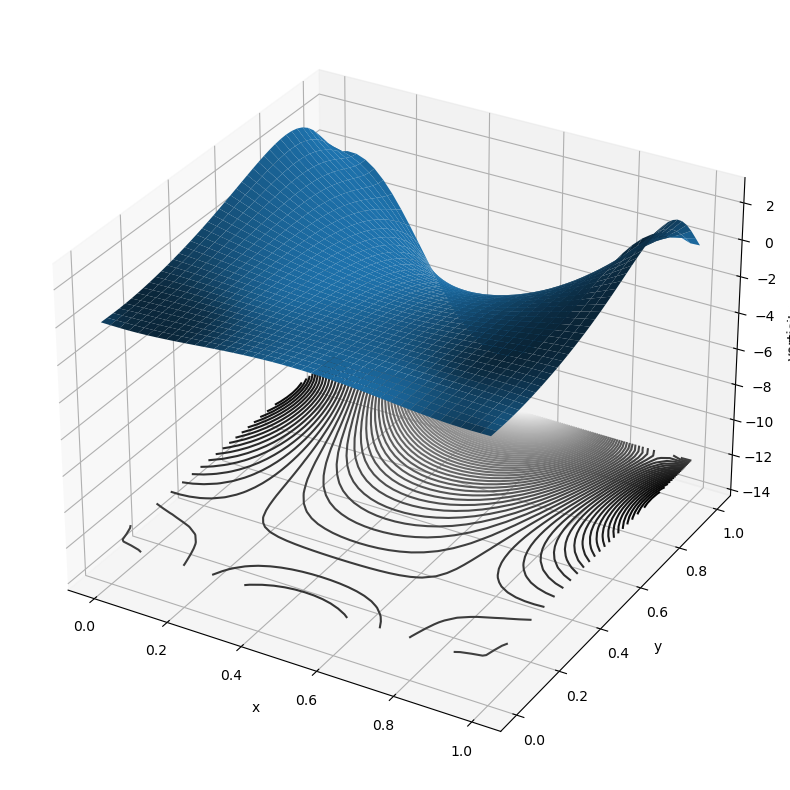

In [ ]:
plot(
    x=x_grid, y=y_grid, z=w,
    label="vorticity", levels=80,
    offset=-12, zlim=(-14, 3)
)

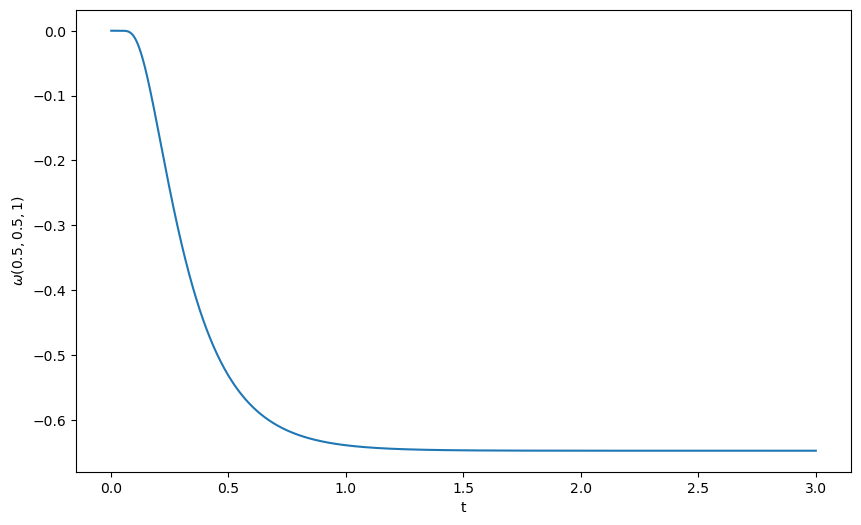

In [ ]:
plt.figure(figsize=(10, 6))

dt = 0.2 * Re * h ** 2
time = np.arange(dt, tfinal + dt, dt)
plt.plot(time, omega_mid)

plt.xlabel("t")
plt.ylabel(r"$\omega(0.5, 0.5, 1)$")
plt.show()

In [ ]:
# xy = np.vstack([time, omega_mid]).T
# print(xy.shape)

# np.savetxt('data/vorticity/time_to_steady.txt', xy, delimiter=' ', fmt=['%.8f', '%.18f'])

In [ ]:
# Accurate to 4 sf after
for i in range(50, len(omega_mid)):
    if np.isclose(np.round(np.abs(omega_mid[i] - omega_mid[i - 1]), 4), 0.0):
        print(time[i])
        break

1.0200000000000002


# Exercise 4

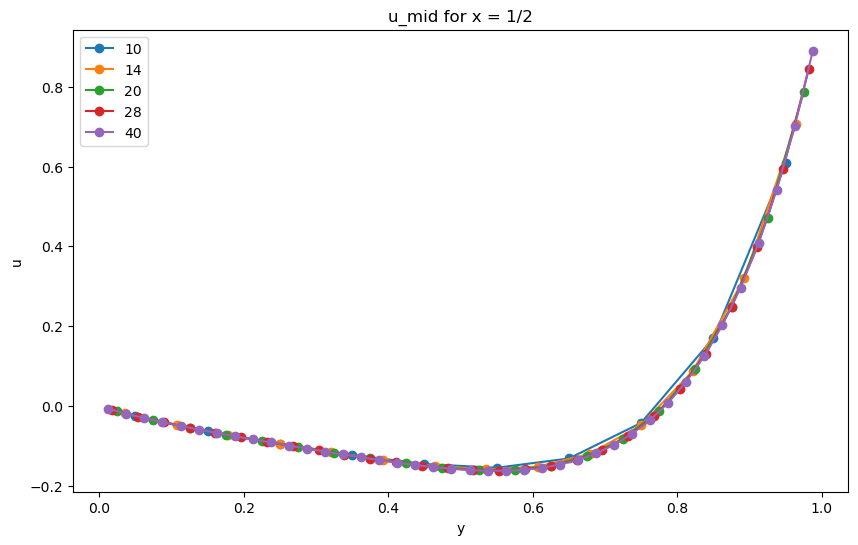

CPU times: user 34.5 s, sys: 566 ms, total: 35 s
Wall time: 42.2 s


In [ ]:
%%time

Re = 10 # i.e. mu = 0.1

tfinal = 3.0

plt.figure(figsize=(10, 6))
for N in [10, 14, 20, 28, 40]:
    U_wall_top = np.sin(np.pi * np.arange(1, N) / N) ** 2
    w, psi, _ = streamfunction_vorticity_iterative_solver(
        N=N, Re=Re, tfinal=tfinal, U_wall_top=U_wall_top
    )

    i = (N + 1) // 2
    h = 1 / N
    _, y_grid = np.meshgrid(
        np.linspace(0, 1, N + 1), np.linspace(0, 1, N + 1), indexing="ij"
    )
    u_mid = (psi[i, 1:] - psi[i, :-1]) / h
    plt.plot(y_grid[i, :-1] + h / 2, u_mid, label=N, marker="o")
    
    
plt.xlabel("y");
plt.ylabel("u")
plt.title("u_mid for x = 1/2")
plt.legend()

plt.show()

# Exercise 5

In [ ]:
%%time

Re = 10 # i.e. mu = 0.1

tfinal = 3.0

N_values = np.array([10, 14, 20, 28, 40])
forces = []
for N in N_values:
    print(N)
    U_wall_top = np.sin(np.pi * np.arange(1, N) / N) ** 2
    w, psi, _ = streamfunction_vorticity_iterative_solver(
        N=N, Re=Re, tfinal=tfinal, U_wall_top=U_wall_top
    )
    
    force = core.calculate_force(psi)
    forces.append(force)


10
14
20
28
40
CPU times: user 16.6 s, sys: 388 ms, total: 17 s
Wall time: 20.5 s


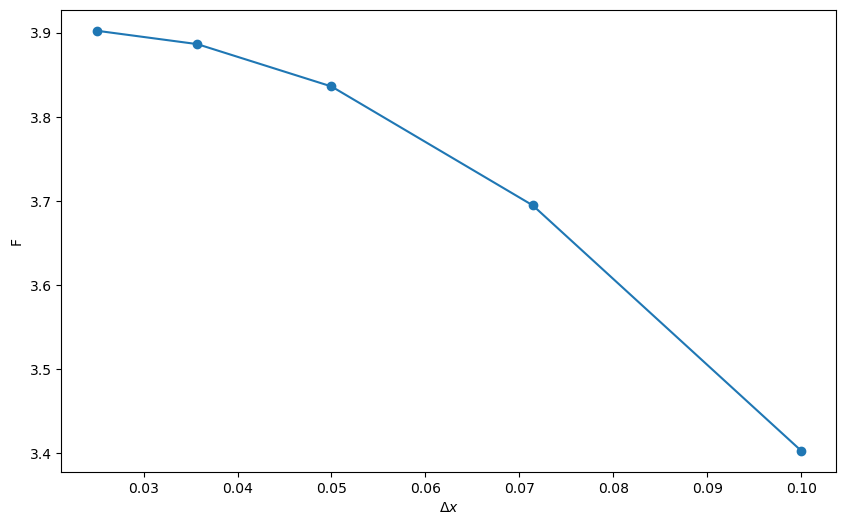

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(1 / N_values, forces, marker="o")
plt.xlabel(r"$\Delta x$")
plt.ylabel("F")

plt.show()

# Exercise 6

In [ ]:
%%time

Re = 10 # i.e. mu = 0.1

tfinal = 3.0

N_values = np.array([10, 14, 20, 28, 40])
forces = []
for N in N_values:
    print(N)
    U_wall_top = np.ones(N - 1)
    w, psi, _ = streamfunction_vorticity_iterative_solver(N=N, Re=Re, tfinal=tfinal, U_wall_top=U_wall_top)
    
    force = core.calculate_force(psi)
    forces.append(force)

10
14
20
28
40
CPU times: user 16.3 s, sys: 237 ms, total: 16.6 s
Wall time: 19.1 s


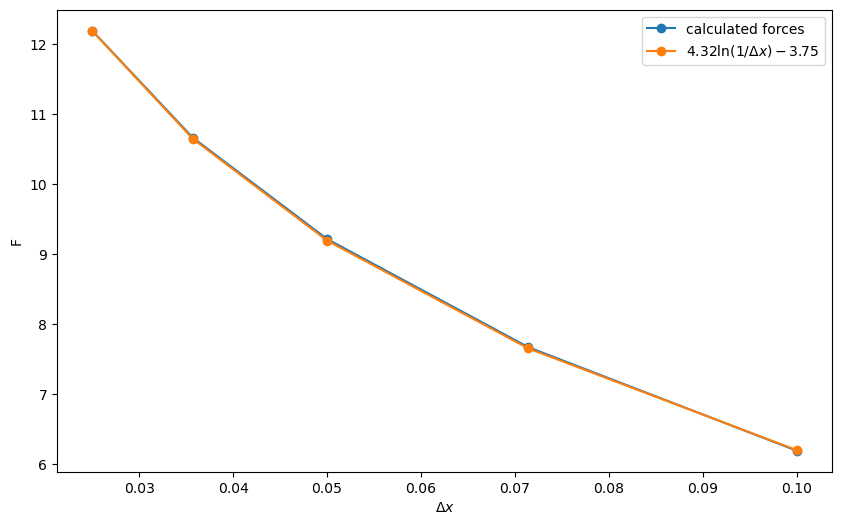

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(1 / N_values, forces, marker="o", label="calculated forces")
plt.plot(1 / N_values, 4.32 * np.log(N_values) - 3.75, marker="o", label=r"$4.32\ln(1/\Delta x) - 3.75$")
plt.xlabel(r"$\Delta x$")
plt.ylabel("F")
plt.legend()

plt.show()

# Export

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()